# XGBoost (eXtreme Gradient Boost)

이전 GBM을 강화한 알고리즘이다. 그래서 분류(Classification)와 회귀(Regression) 문제들 둘 다 사용 가능하다.

바닐라 GBM처럼 잔차(Residual)를 계산하고 이 잔차들을 최소화하는 모델을 만드려고 한다.

하지만, XGBoost는 정규화(regularization)와 근사 알고리즘(Approximate algorithm) 그리고 병렬 학습(Parallel Learning) 같은 추가 기능을 가지고 있다. 따라서 높은 성능과 스피드를 보여준다.

### 목적 함수 (Objective Function)


image.png

목적 함수(objective function)는 손실함수(loss function)와 정규화(Regularization)의 조합이다.

아래 두 개가 손실함수로 사용된다.

- 회귀 : 실제값과 예측값의 차이의 제곱의 합
- 분류 : 크로스 엔트로피

여기서 정규화는 모델의 복잡도를 조정하여, 과적합을 방지한다.

### 정규화 (Regularization)

image.png

A, B, C, D, E를 사람으로 가정하고 있다.

- no of leaves : number of leaves
- w = Leaf weight

r(감마)는 리프의 개수를 조절하는데 사용된다.

- 감마가 높으면, 리프 개수가 적은 단순한 트리를 만들고
- 감마가 낮으면, 리프 개수가 많은 복잡한 트리를 만든다

위에 그림에서 감마 밑에 화살표를 잘 확인할 것.


image.png

람다는 **L2 규제**를 말한다.

- 람다의 값이 크면, 가중치가 작아지고
- 람다의 값이 작아지면, 가중치가 커진다. -> 모델이 훈련 데이터에 더 적합해진다.

람다 밑에 화살표를 잘 확인할 것.



### 그리디 알고리즘 (Greedy Algorithm)

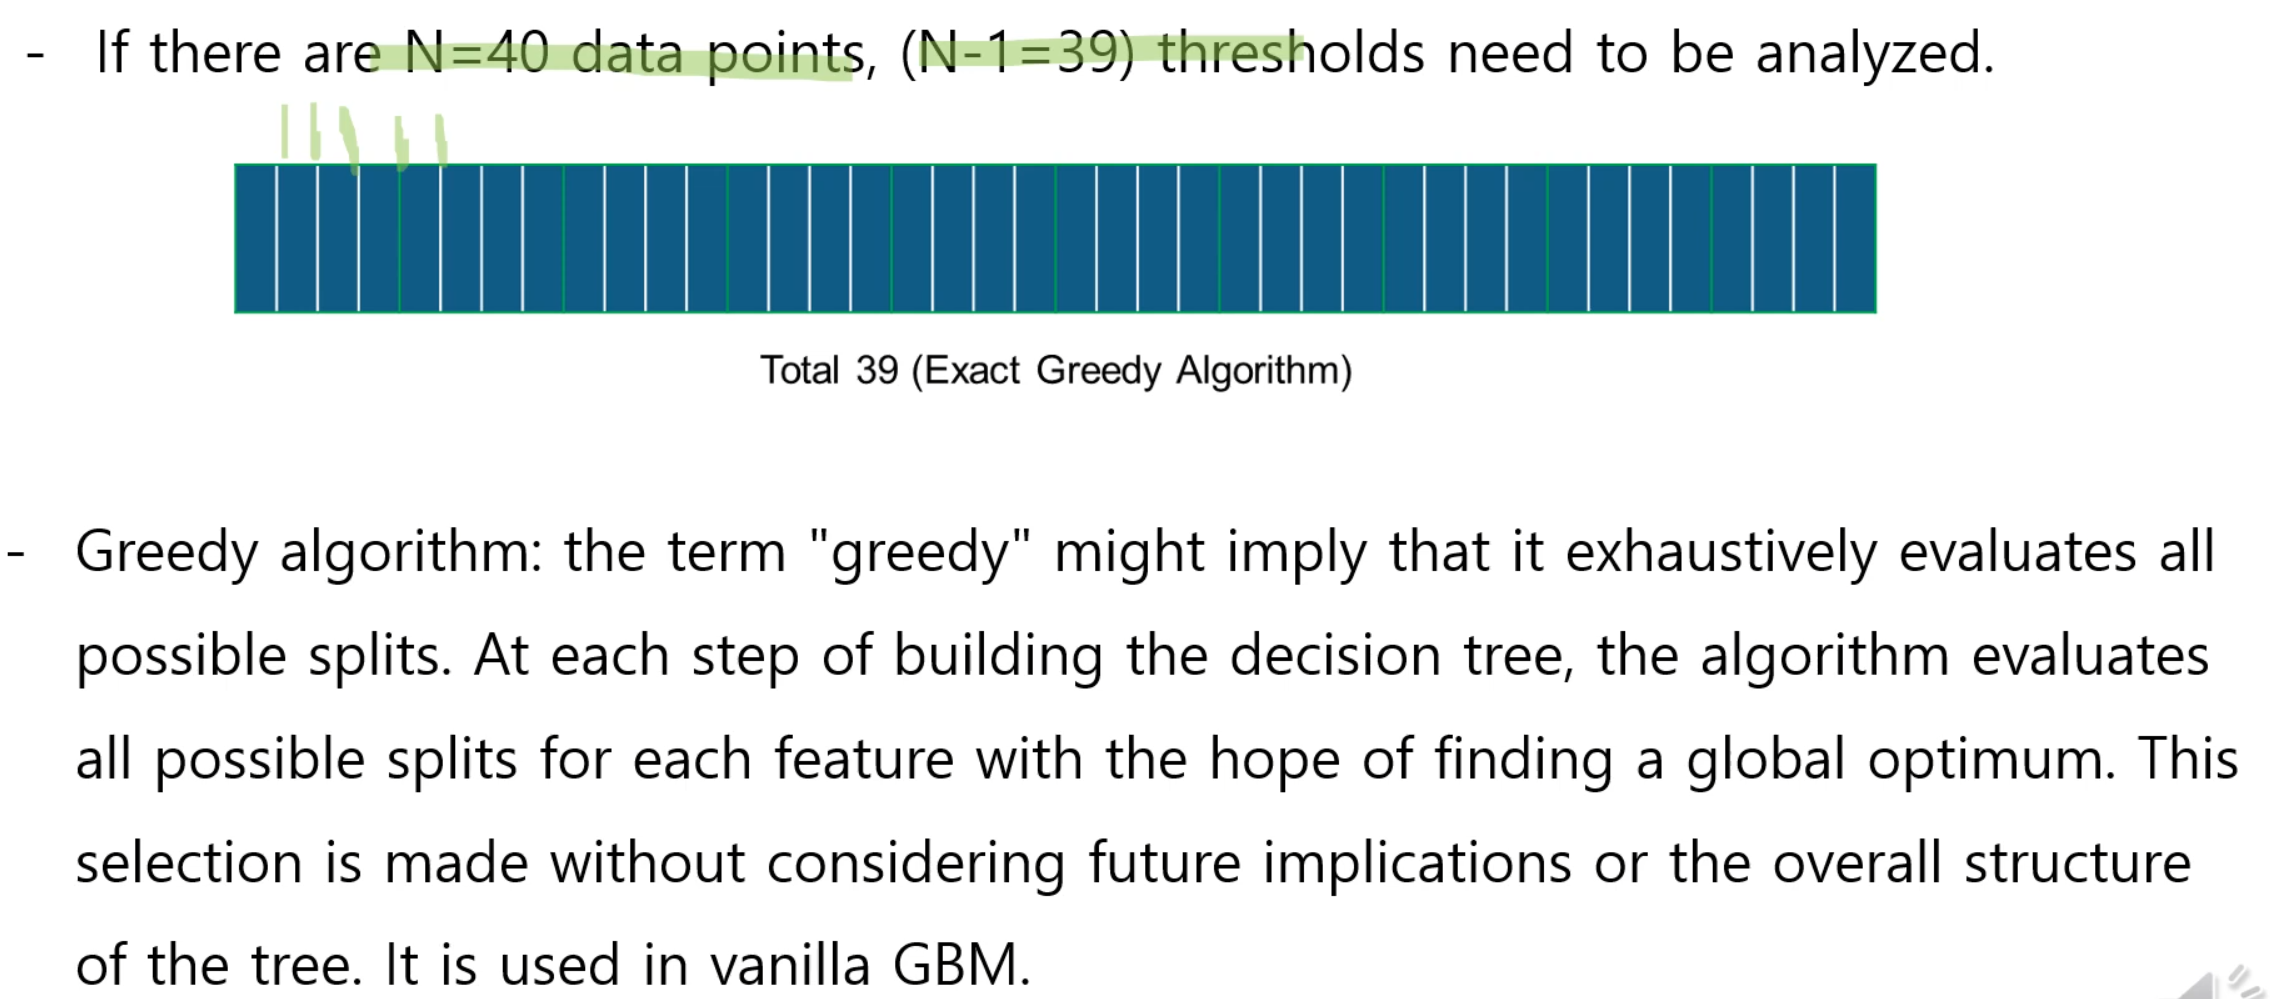

일반 그리디 알고리즘을 사용하게 되면 40개의 데이터 포인트들이 있다고 가정했을 때 임계점(Threshold)를 39개를 갖는다. 이 말은 39개의 분할을 평가해야된다.

Greedy에 말처럼 가능한 모든 분할을 평가하므로써 최적의 해를 찾는다.

하지만, 추후에 결과나 트리의 구조를 고려하지 않는다. Vanilla GBM에서 사용하는 알고리즘이다.


### 근사 그리디 알고리즘(Aproximate Greedy Algorithm)



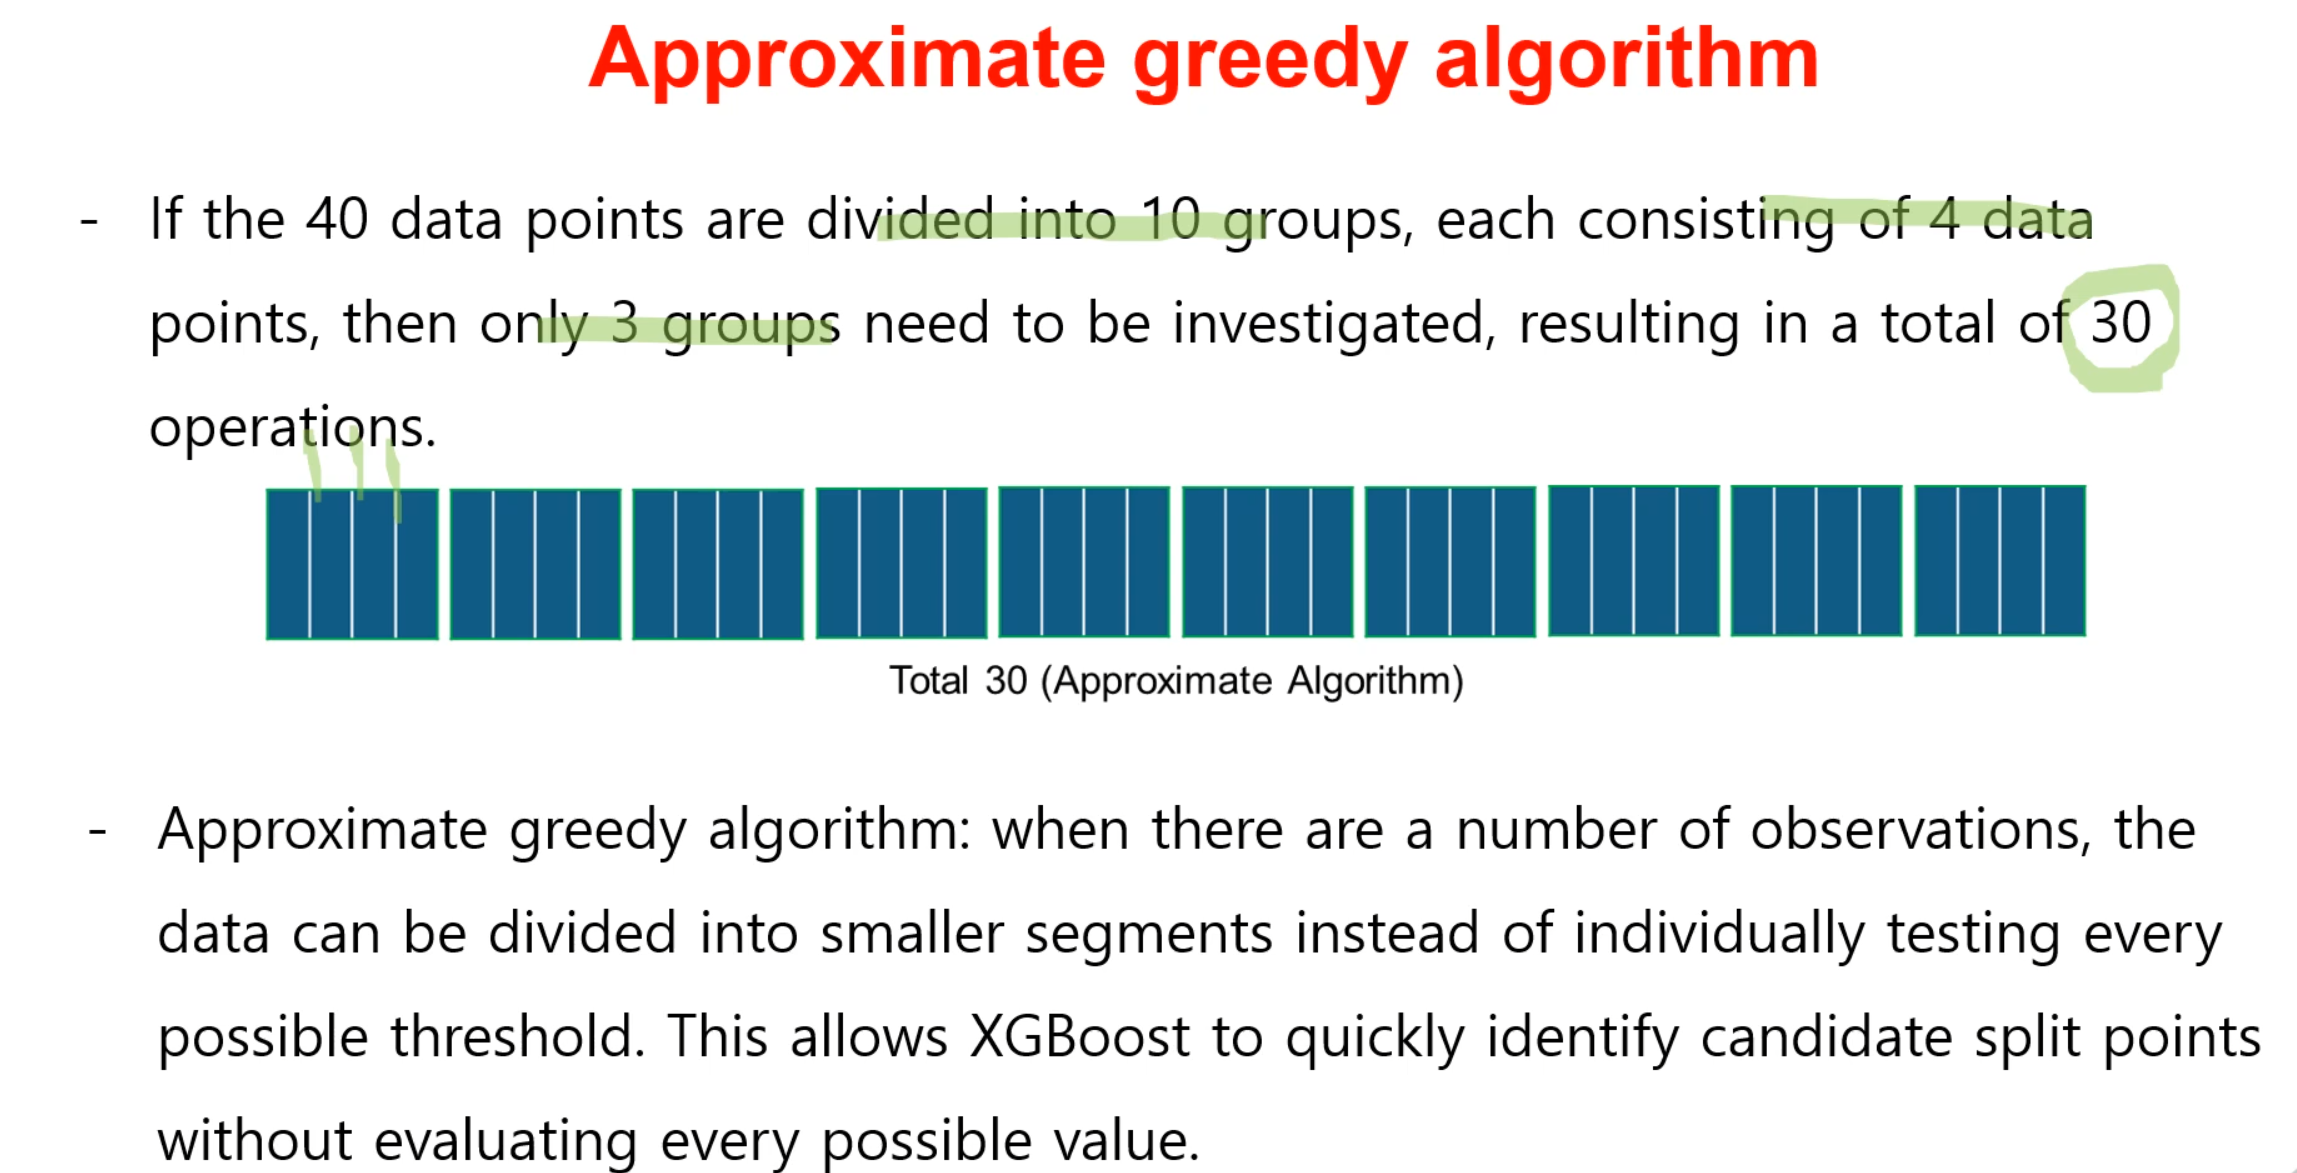

40개의 데이터를 10그룹으로 나눈다. 각 그룹은 4개의 데이터들을 가지고 3개의 임계점을 가진다.

결과적으로 앞서 말한 일반 그리디 알고리즘보다 더 적은 30번만 연산하면 된다. 그래서 더 효율적이다.

### 병렬 학습 (Parallel Learning)

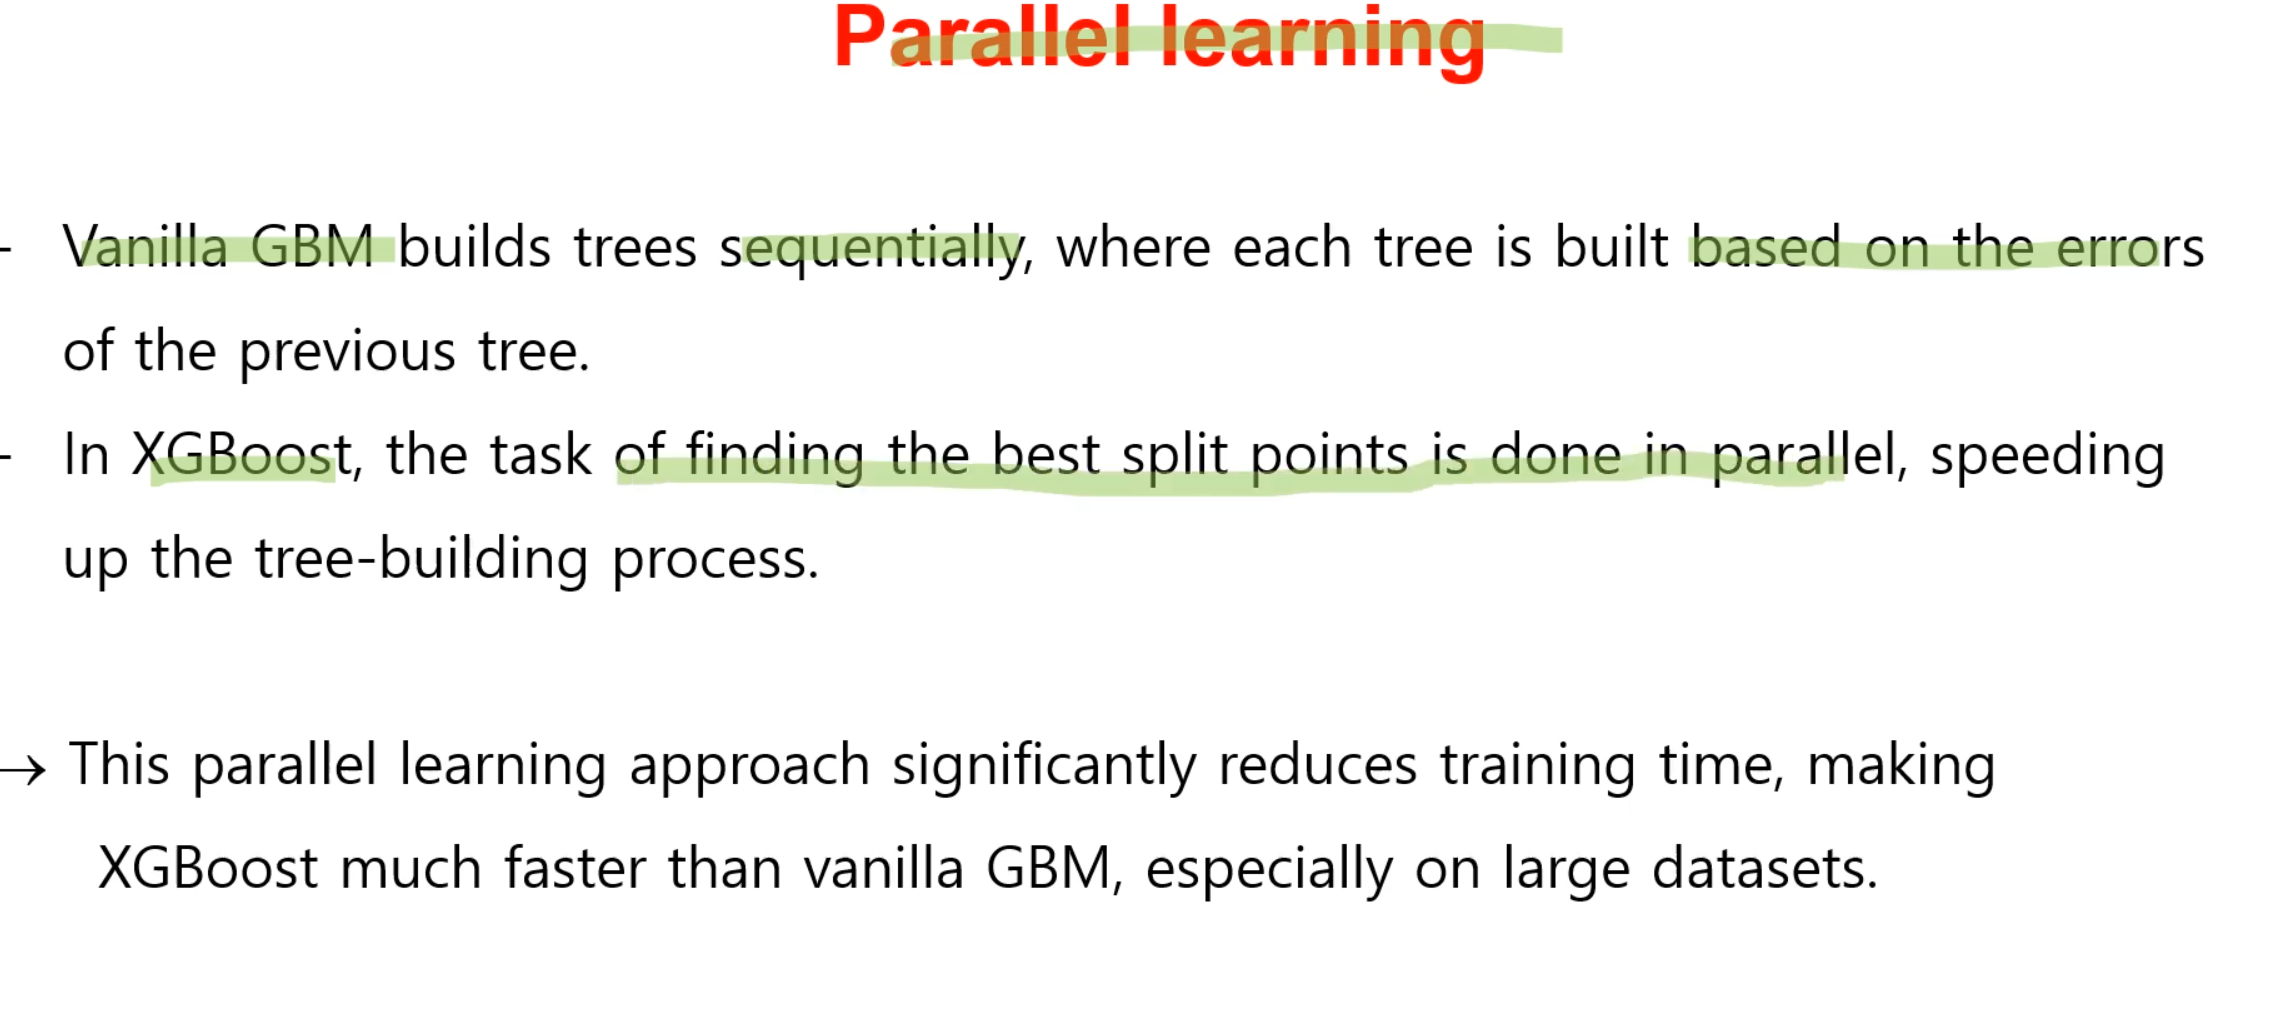

바닐라 GBM처럼 순서대로 오차율을 통해 분할하는 것과 다르게,

**병렬로 데이터 포인트들을 분할 하기 때문에 훨씬 빠르다.**

# - 실습

### 1. 라이브러리 / 데이터셋 가져오기

In [64]:
import numpy as np
import pandas as pd
import seaborn as sns

planets = sns.load_dataset('planets')
print(planets['number'].unique())
print(planets)


[1 2 3 5 4 6 7]
               method  number  orbital_period   mass  distance  year
0     Radial Velocity       1      269.300000   7.10     77.40  2006
1     Radial Velocity       1      874.774000   2.21     56.95  2008
2     Radial Velocity       1      763.000000   2.60     19.84  2011
3     Radial Velocity       1      326.030000  19.40    110.62  2007
4     Radial Velocity       1      516.220000  10.50    119.47  2009
...               ...     ...             ...    ...       ...   ...
1030          Transit       1        3.941507    NaN    172.00  2006
1031          Transit       1        2.615864    NaN    148.00  2007
1032          Transit       1        3.191524    NaN    174.00  2007
1033          Transit       1        4.125083    NaN    293.00  2008
1034          Transit       1        4.187757    NaN    260.00  2008

[1035 rows x 6 columns]


2. 데이터 전처리

In [63]:
from sklearn.preprocessing import LabelEncoder

# planets.dropna(inplace = True) # 원본 데이터프레임에서 NaN 값이 포함된 행 삭제

planets['method'] = LabelEncoder().fit_transform(planets['method'])

planets['orbital_period'] = planets['orbital_period'].fillna(planets['orbital_period'].mean())
planets['mass'] = planets['mass'].fillna(planets['mass'].mean())
planets['distance'] = planets['distance'].fillna(planets['distance'].mean())

# print(planets['method'])
print(planets.isnull().sum())

X = planets[['method', 'orbital_period', 'mass', 'distance', 'year']]
y = planets['number']

print(X)
print(y)

method            0
number            0
orbital_period    0
mass              0
distance          0
year              0
dtype: int64
number
1    595
2    259
3     88
4     32
5     30
6     24
7      7
Name: count, dtype: int64
      method  orbital_period       mass  distance  year
0          7      269.300000   7.100000     77.40  2006
1          7      874.774000   2.210000     56.95  2008
2          7      763.000000   2.600000     19.84  2011
3          7      326.030000  19.400000    110.62  2007
4          7      516.220000  10.500000    119.47  2009
...      ...             ...        ...       ...   ...
1030       8        3.941507   2.638161    172.00  2006
1031       8        2.615864   2.638161    148.00  2007
1032       8        3.191524   2.638161    174.00  2007
1033       8        4.125083   2.638161    293.00  2008
1034       8        4.187757   2.638161    260.00  2008

[1035 rows x 5 columns]
0       1
1       1
2       1
3       1
4       1
       ..
1030    1
1031

3. 학습용/ 시험용 데이터셋 분리

In [53]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)


4. 정규화

In [54]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
# fit: 데이터를 기준으로 변환 규칙(평균과 표준편차)을 계산
# transform: 계산된 규칙을 사용하여 데이터를 변환
# 한번 fit하면 fit단계에서 scalar 객체에 평균과 표준편차가 저장된다.
# 그래서 Test에서는 transform만 사용하여,
# 이 지정된 값(훈련 데이터에서 계산한 것)만 변환한다.

X_test = scaler.transform(X_test)

5. DMatix 생성 및 모델 생성

In [73]:
import xgboost
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# DMatrix 생성
dtrain = xgboost.DMatrix(X_train, label=y_train)
dtest = xgboost.DMatrix(X_test, label=y_test)

# XGBoost 파라미터 설정
params = {
    "objective": "multi:softmax",
    "num_class": 8,
    "max_depth": 5,
    "eta": 0.1,
    "seed": 42
}

# 모델 학습
num_round = 200
bst = xgboost.train(params, dtrain, num_round)

# 예측
y_pred = bst.predict(dtest)

# 정확도 평가
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

print(classification_report(y_test, y_pred))


Accuracy: 0.70
              precision    recall  f1-score   support

           1       0.78      0.88      0.82       178
           2       0.51      0.56      0.53        72
           3       0.64      0.21      0.32        33
           4       0.60      0.27      0.38        11
           5       0.86      0.67      0.75         9
           6       0.62      0.71      0.67         7
           7       1.00      1.00      1.00         1

    accuracy                           0.70       311
   macro avg       0.72      0.61      0.64       311
weighted avg       0.69      0.70      0.68       311

